**What does this pipeline do?**
   This pipeline is built to process 3' end sequencing data generated using the [3'READS+ method](https://www.ncbi.nlm.nih.gov/pubmed/27512124 "Pubmed"), which produces sequencing reads with ~13 Ts in the beginning of the reads. Reads containing >= 2 extra Ts originated from the poly(A) tail cannot be mapped to the genome and therefore are called PASS (PolyA Site Supporting) reads. The pipeline will search fastq files on the intron server, merge fastq files, do fastq QC, trim 3' adapter, trim 5' Ts, map reads to the genome, identify PASS reads and unique PASS reads, cluster PASS reads for defining poly(A) sites, and create genome browser tracks. Along the way it will generate a fastq QC report, a read statistics report, and a plot showing distributions of 5' T-stretch length.


**What's cool about this pipeline?**
 * I used both python and R seamlessly in one notebook. It is a great pleasure to mix python and R!
 * I used parallel computing in in both python and R for all the heavy-lifting steps. It only took ~50 min to process 29 G fastq data for 8 samples on a laptop workstation (Lenovo P50 with 4 cores and 48G RAM).
 * I developed my own algorithms to identify PASS reads and cluster them. The clustering algorithm uses a divide and conquer technique to cluster neighbouring cleavage sites due to microheterogeneity.   

In [55]:
%load_ext rpy2.ipython 
%load_ext autoreload
%autoreload 2
%matplotlib inline

import rpy2.robjects.numpy2ri as n2r
from time import sleep
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append('modules')
from PASS import *

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set parameters specific to this project and experiment
These parameters can be different for different runs. The sample discription file is in csv format with at least the following columns: "prefix" (unique beginning strings in the fastq files), "sample" (user defined sample name). This information can be used to make sample names more meaningful. "color_group" is optional, but can be used to groups different UCSC tracks by color. If not specified, a unique color will be used for each sample.

In [56]:
PROJECT = 'example' # project name

EXPERIMENT = '181210' # experiment name

GENOME = 'hg19' # genome name, either mm9 or hg19

SEQUENCER = 'nextseq' # Either "hiseq" or "nextseq"

SAMPLE_DESCRIPTION_FILE = 'sample_description.csv' # sample discription file.

MAKE_URL = True

DATA_SOURCE = 'local'
    
FASTQ_QC_PLOT_NUM_COLUMNS = 4  # number of columns for fastq QC plots

SAVE_SPACE = False # to save space, delete intermediate files asap.    

SPIKE_IN = None # A 4-charactor string for identifying spike-in RNA. For example, 'ychr' for yeast RNA spike-in if yeast chromosomes are named as 'ychr*'.


## Set general parameters
No need to change anything below for different runs.

In [57]:
if DATA_SOURCE == 'internal_server':
    USER = 'zhengdh'
    SERVER = 'intron.njms.rutgers.edu'
elif DATA_SOURCE == 'basespace':
    BASESPACE_PROJECT = ''
    BASESPACE_TOKEN = ''
elif DATA_SOURCE == 'local':
    LOCAL_DATA_SOURCE = '/home/dinghai/dev/3-prime-READS-plus/tests/data'
    assert Path(LOCAL_DATA_SOURCE).exists()
    
if MAKE_URL:
    USER = 'zhengdh'
    SERVER = 'intron.njms.rutgers.edu'

GENOME_INDEX_DIR = '/home/dinghai/projects/fud/star_index' # Directory containing index files for different genomes
GENOME_FASTA_DIR = '/home/dinghai/projects/fud/ucsc/genomes' # Directory containing fasta files for different genomes
# Genome index for STAR
genome_index = Path(GENOME_INDEX_DIR)/GENOME
# Genome sequence in fasta format for identifying PASS reads
genome_dir = Path(GENOME_FASTA_DIR)/GENOME
assert genome_index.exists(), f"Please make sure the following genome index folder exists: {str(genome_index)}"
assert genome_dir.exists(), f"Please make sure the following genome fasta file folder exists: {str(genome_dir)}"

MAX_WORKERS = 8  # Maximum number of processes for parallel computing
CUTADAPT_MINLEN = 25  # Minimum read lenth after removing 5' adapter
MIN_MAPQ = 10 # Minimum MAPQ score for alignments in STAR output 
SEQ_DIRECTION = 'reverse' # Sequencing direction relative to mRNA sequence. Either 'reverse' or 'forward'.

MAX_PA_DISTANCE = 24 # Maximum distance between clustered reads

# Paths to other tools
samtools = '~/tools/ucsc/samtools '
genomeCoverageBed = '~/tools/ucsc/genomeCoverageBed '
genome_size = '~/projects/fud/ucsc/genomes/' + GENOME + '.chrom.sizes'
bedGraphToBigWig = '~/tools/ucsc/bedGraphToBigWig '

In [58]:
# Project directory
project_dir = Path('projects')/PROJECT
# Script directory for saving project and experiment-specific scripts
script_dir = project_dir/'scripts'/EXPERIMENT
# Data directories
data_dir = project_dir/'data'/EXPERIMENT
rawfastq_dir = data_dir/'rawfastq'
fastq_dir = data_dir/'fastq'
sam_dir = data_dir/'sam'
# Result directory
result_dir = project_dir/'result'/EXPERIMENT
result_dir_str = str(result_dir.absolute()) # For R code
# Create directories
project_dir.mkdir(parents=True, exist_ok=True)
script_dir.mkdir(parents=True, exist_ok=True)
data_dir.mkdir(parents=True, exist_ok=True)
rawfastq_dir.mkdir(parents=True, exist_ok=True)
fastq_dir.mkdir(parents=True, exist_ok=True)
sam_dir.mkdir(parents=True, exist_ok=True)
result_dir.mkdir(parents=True, exist_ok=True)

## Read sample annotation and choosing colors for UCSC tracks


Sample description:


,warehouse_folder_unique_string,fastq_file_string,sample,genome_browser_track_color
0,181210,siCtrl_1,siCtrl_1,1
1,181210,siYfg_1,siYfg_1,2
2,181210,siCtrl_2,siCtrl_2,1
3,181210,siYfg_2,siYfg_2,2


The following colors will be used for UCSC genome browser tracks:


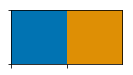

In [59]:
sample_description = pd.read_csv(data_dir/SAMPLE_DESCRIPTION_FILE, dtype = 'str')

if not set(['warehouse_folder_unique_string', 'fastq_file_string', 'sample']) <= set(sample_description.columns):
    msg = (f'The sample discription file should at least have the following columns:\n'
           f'"warehouse_folder_string": unique string in the name of the data warehouse folder '
           f'containing the fastq files.\n'
           f'"fastq_file_string": string in the fastq files for mapping fastq files to samples.\n'
           f'"sample": user defined sample name.'
          )
    print(msg)
    
# Remove potential whitespace 
sample_description.apply(lambda x: x.str.strip(), axis=1)
sample_description.genome_browser_track_color = sample_description.genome_browser_track_color.astype(int)

print("\nSample description:")
display(sample_description)    

print('The following colors will be used for UCSC genome browser tracks:')
if 'genome_browser_track_color' in sample_description.columns:
    color_max = sample_description.genome_browser_track_color.max(axis=0)
else:
    color_max = sample_description.shape[0]
    
sns.palplot(sns.color_palette("colorblind", color_max))

## Find, download, merge, and rename fastq files
Fastq files with the same file_string will be merged and renamed using the corresponding "sample" name defined in sample_description.csv.

In [60]:
for folder_string in sample_description.warehouse_folder_unique_string.unique():
    df = sample_description[sample_description.warehouse_folder_unique_string == folder_string]
    rawfastq_subdir = rawfastq_dir/folder_string
    rawfastq_subdir.mkdir(parents=True, exist_ok=True)
    
    if DATA_SOURCE == 'internal_server':
        # Find folder in the warehouse that may contain the fastq files
        cmd = f'ssh {USER}@{SERVER} find ../database* -type d -name *{folder_string}*'
        print(f'\nLooking for folders with {folder_string} in their names on the server {SERVER}')
        print(f'\nUsing command {cmd}')
        fastq_folders = check_output(cmd, shell=True).decode().split('\n')
        print('\nFastq folders found:')
        print('\n'.join(fastq_folders))

        # Find fastq files in the folders
        for file_string in df.fastq_file_string:
            # Some of the folders may not contain fastq data
            for fastq_folder in fastq_folders:
                if SEQUENCER == "hiseq":
                    cmd = f'ssh {USER}@{SERVER} find {fastq_folder} -type f -name *{file_string}*R1*'
                elif SEQUENCER == "nextseq":
                    cmd = f'ssh {USER}@{SERVER} find {fastq_folder} -type f -name *{file_string}*'
                print(f'\nSerching files using the command {cmd}')
                fastq_files = check_output(cmd, shell=True).decode().replace('\n', " ")
                # Escape special characters
                fastq_files = fastq_files.replace("&", "\&").replace(":", "\:")
                print('\nFastq files found:')
                print(fastq_files, '\n')
                # Skip the current fastq_folder if fastq_files have already been found
                if not fastq_files == '': 
                    break
            # Download fastq files from internal server
            print('\nDownloading fastq files ....')
            cmd = f'scp {USER}@{SERVER}:"{fastq_files}" {rawfastq_subdir}'
            os.system(cmd)

            # Find fastq file names begining with file_string
            fastq_gz_with_file_string = [str(filename) for filename in rawfastq_subdir.iterdir() 
                                         if re.search(file_string + '.+fastq.gz$', str(filename))]
            
            fastq_with_file_string = [str(filename) for filename in rawfastq_subdir.iterdir() 
                                         if re.search(file_string + '.+fastq$', str(filename))]
            
            merge_and_rename(fastq_gz_with_file_string, df, file_string, rawfastq_dir)
            merge_and_rename(fastq_with_file_string, df, file_string, rawfastq_dir)
        
    elif DATA_SOURCE == 'local':
        cmd = f'find {LOCAL_DATA_SOURCE} -type d -name *{folder_string}*'
        # On the local computer, there is usually just one folder for each data set.
        fastq_folder = check_output(cmd, shell=True).decode().strip() 
        print('\nLocal fastq folders found:', fastq_folder)

        # Find fastq files in the folders
        for file_string in df.fastq_file_string:
            if SEQUENCER == "hiseq":
                # find fastq file names begining with file_string
                fastq_gz_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                             if re.search(file_string + '.*R1.+fastq.gz$', str(filename))]
                fastq_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                          if re.search(file_string + '.*R1.+fastq$', str(filename))]
            elif SEQUENCER == "nextseq":
                fastq_gz_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                             if re.search(file_string + '.+fastq.gz$', str(filename))]
                fastq_with_file_string = [str(filename) for filename in Path(fastq_folder).iterdir() 
                                          if re.search(file_string + '.+fastq$', str(filename))]
            
            merge_and_rename(fastq_gz_with_file_string, df, file_string, rawfastq_dir)
            merge_and_rename(fastq_with_file_string, df, file_string, rawfastq_dir)
    
    elif DATA_SOURCE == 'basespace':
        pass


Local fastq folders found: /home/dinghai/dev/3-prime-READS-plus/tests/data/181210


In [61]:
fastq_files = sorted([str(filename.absolute()) for filename in rawfastq_dir.glob('*.fastq')])

if len(fastq_files) == 0:
    print(f"\nPleae put fastq files in the {str(rawfastq_dir)} folder first.")    
    
WORKERS = min(MAX_WORKERS, len(fastq_files))

print(f'\n{WORKERS} workers will be used for all parallel computing.')    


4 workers will be used for all parallel computing.


In [62]:
# Count raw reads   
with mp.Pool(processes=WORKERS) as pool:
    raw_fastq_counts = pool.map(count_fastq, fastq_files)
    
raw_fastq_counts = pd.DataFrame(raw_fastq_counts, columns = ["File_Name", "Raw"])
raw_fastq_counts["File_Name"] = raw_fastq_counts["File_Name"].str.replace('.fastq', '') 
raw_fastq_counts = raw_fastq_counts.set_index("File_Name")

print('\nRaw fastq counts in each file:')
raw_fastq_counts 


Raw fastq counts in each file:


,Raw
File_Name,
siCtrl_1,250
siCtrl_2,250
siYfg_1,250
siYfg_2,250


## FASTQ QC using R
1. python list -> R list (not vector)
2. Multiple inputs after -i can be separated using ",", without space.

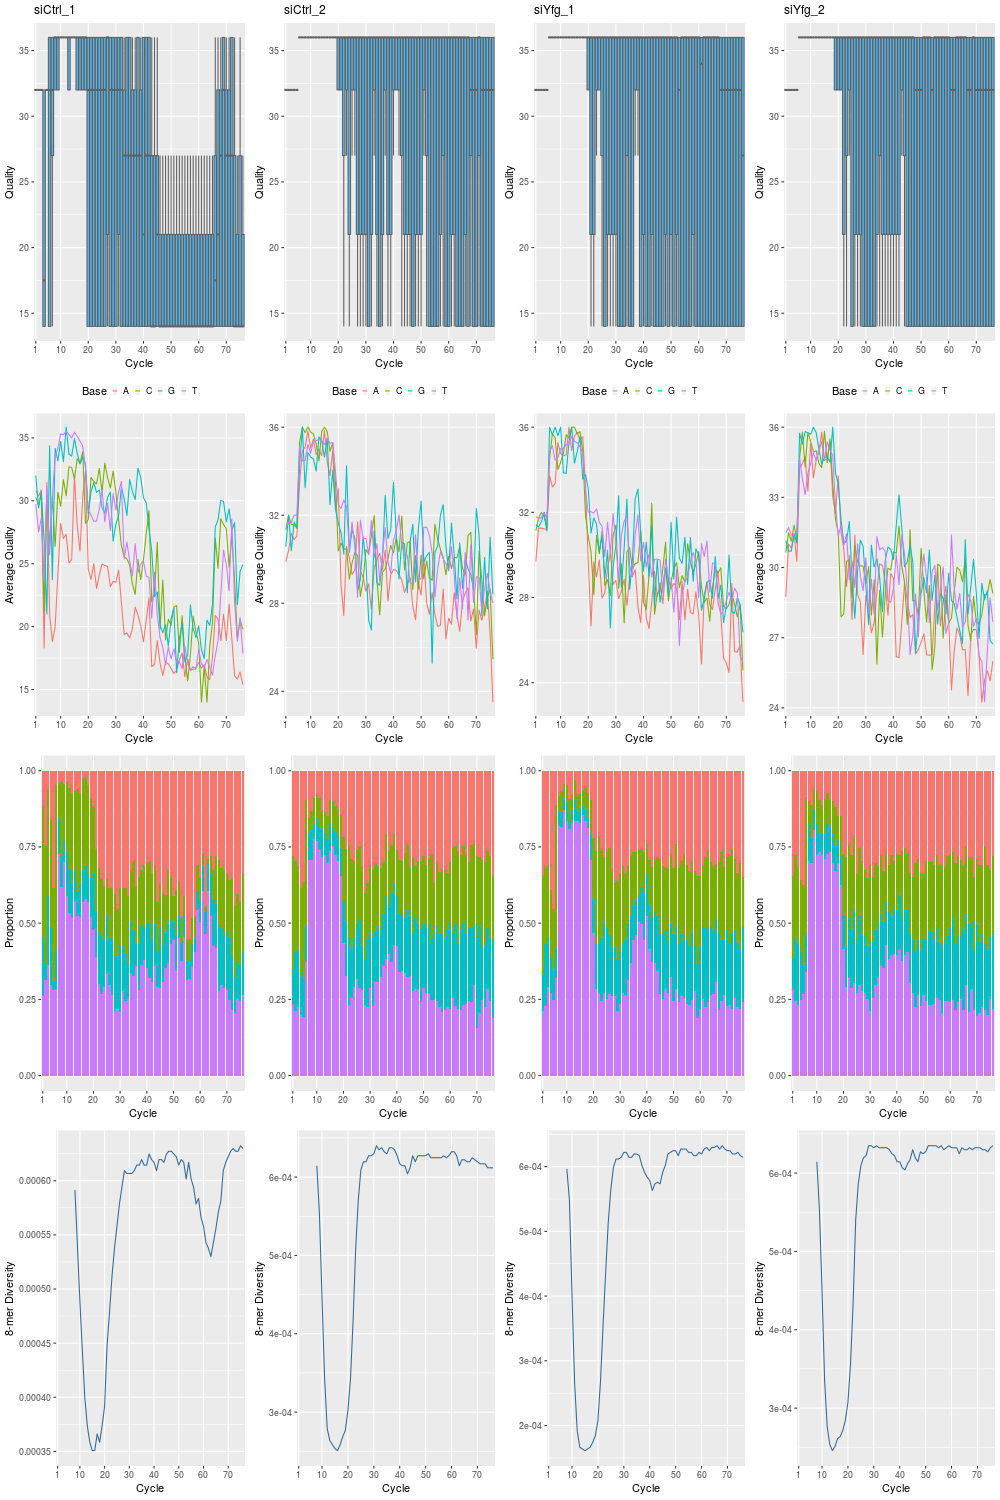

In [63]:
%%R -i fastq_files,FASTQ_QC_PLOT_NUM_COLUMNS,result_dir_str,WORKERS -w 1000 -h 1500

## Load helper functions
source("modules/FastqQC.R")
library(foreach)
library(doParallel)

## Step 1: Creat list of plots using parellel computing             
registerDoParallel(WORKERS)   
fqlist = foreach(f = 1:length(fastq_files), 
                 .packages = c("ShortRead", "Biostrings")) %dopar%{
    seeFastq(fastq = fastq_files[[f]])
    }
names(fqlist) = sapply(fastq_files, function(x) sub(".+\\/(.+).fastq", "\\1", x))                     

## Step 2: Output pdf and browser image              
mycol = seq(along = fqlist)     
myrow = c(1, 3, 2, 4)
n = min(FASTQ_QC_PLOT_NUM_COLUMNS, length(fastq_files))                                                
if(length(mycol) %% n){
  groups = 0:floor(length(mycol)/n)
}else{
  groups = 0:(length(mycol)/n - 1)
}  
                       
# Make pdf plots                        
pdf(file.path(result_dir_str, "fastqReport.pdf"), height=20, width=4*n)                         
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange = myrow, n = n)
}
dev.off()  
                       
# Print to screen
for(group in groups){
  if(group < max(groups)){
    subcol = mycol[n*group + 1:n]
  }else{
    subcol = mycol[(n*group + 1):length(mycol)]
  }
  seeFastqPlot(fqlist[subcol], arrange = myrow, n = n)
} 

**Automatically figure out the number of random nucleotides in the 3' adapter (5' end of the reads when the libraries are sequenced in reverse direction)** Usually the base after the random nucleotides has the highest frequency of Ts.

In [64]:
%%R -o random_NT_lens
cycle_with_max_T_frequency = function(fq){
    base_frequency = fq$bstats
    T_frequency = subset(base_frequency, Base == "T")
    # The number of random nucleotides in the 3'adapter is also where the frequency of T increased most 
    which.max(diff(T_frequency$Frequency))
}

# For libraries prepared using different versions of 3' adapters (usually in different batches), 
# the numbers of random nucleotides could be different
random_NT_lens = sapply(fqlist, cycle_with_max_T_frequency)
names(random_NT_lens) = names(fqlist)

cat("\nNumber of random nucleotides in 5' end of the fastq reads (due to 3' ligation adapter):\n\n")
print(random_NT_lens)
cat("\n")


Number of random nucleotides in 5' end of the fastq reads (due to 3' ligation adapter):

siCtrl_1 siCtrl_2  siYfg_1  siYfg_2 
       6        6        6        6 



## Clip adapters 

In [65]:
if SEQUENCER == 'hiseq':
    # Clip the read's 3' end adapter (originated from 5' RNA ligation adapter) and only keep 80 (150-70) nt
    cmds = [(f'cutadapt -u -70 -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m {CUTADAPT_MINLEN} -f fastq '
             f'-q 10 {fastq_file} -o {fastq_file.replace(".fastq", ".cut.fastq").replace("rawfastq", "fastq")} '
             f'&& rm {fastq_file}') for fastq_file in fastq_files]
    
elif SEQUENCER == 'nextseq':
    # Clip the read's 3' end adapter (originated from 5' RNA ligation adapter)
    cmds = [(f'cutadapt -a NNNNTGGAATTCTCGGGTGCCAAGG -n 1 -O 10 -m {CUTADAPT_MINLEN} -f fastq -q 10 {fastq_file} '
             f'-o {fastq_file.replace(".fastq", ".cut.fastq").replace("rawfastq", "fastq")} '
             f'&& rm {fastq_file}') for fastq_file in fastq_files]

print("\nRemoving ligation adapters from fastq reads in the following files:\n") 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in fastq_files]))

with mp.Pool(processes = WORKERS) as pool: 
    pool.map(os.system, cmds)
    
print('\nDone!')


Removing ligation adapters from fastq reads in the following files:

siCtrl_1.fastq
siCtrl_2.fastq
siYfg_1.fastq
siYfg_2.fastq

Done!


## Trim 5' Ts 

In [66]:
cutadapt_outputs = sorted([str(filename.absolute()) for filename in fastq_dir.glob('*cut.fastq')])

print("\nTrimming 5' T-stretches from fastq reads in the following files:\n") 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in cutadapt_outputs]))

with mp.Pool(processes = WORKERS) as pool:
    trimmed_fastq_counts = pool.starmap(trim_write_count_fastq, 
                            list(zip(cutadapt_outputs, list(random_NT_lens), [4]*len(random_NT_lens))))
    
if SAVE_SPACE:
    cmd = 'rm ' + ' '.join(cutadapt_outputs)
    os.system(cmd)    

print('\nDone!')

trimmed_fastq_counts = pd.DataFrame(trimmed_fastq_counts, columns = ["File_Name", "CutAdapt", "Trimmed"])
trimmed_fastq_counts["File_Name"] = trimmed_fastq_counts["File_Name"].str.replace('.cut.fastq', '')  
trimmed_fastq_counts = trimmed_fastq_counts.set_index("File_Name")
fastq_counts = pd.concat([raw_fastq_counts, trimmed_fastq_counts], axis = 1)

print('\nFastq counts in each file:')
fastq_counts


Trimming 5' T-stretches from fastq reads in the following files:

siCtrl_1.cut.fastq
siCtrl_2.cut.fastq
siYfg_1.cut.fastq
siYfg_2.cut.fastq

Done!

Fastq counts in each file:


,Raw,CutAdapt,Trimmed
File_Name,,,
siCtrl_1,250,250,182
siCtrl_2,250,247,175
siYfg_1,250,247,203
siYfg_2,250,249,176


## Map the reads to the genome using STAR 

AlignEndsType is set to EndToEnd.
According to the STAR manual, add the following lines to /etc/sysctl.conf:
1. kernel.shmmax = 31000000000 
2. kernel.shmall = 7568360

Then run 'sudo /sbin/sysctl -p' to allow large shared memory blocks.

In [67]:
trimmed_fastq_files = sorted([str(filename.absolute()) for filename in fastq_dir.glob('*trimmed.fastq')])
# Commands for mapping reads
cmds = [(f'STAR --runThreadN {WORKERS} --genomeDir {genome_index} --genomeLoad LoadAndKeep '
         f'--readFilesIn {fastq_file} --alignEndsType EndToEnd --outFilterType BySJout '
         f'--outFilterMultimapNmax 10 --alignSJoverhangMin 8 --alignSJDBoverhangMin 1 '
         f'--alignIntronMin 20 --alignIntronMax 1000000 --outFileNamePrefix '
         f'{fastq_file.replace("/fastq/", "/sam/").replace("cut.trimmed.fastq", "")}') 
         for fastq_file in trimmed_fastq_files]

# Commands for removing fastq files
cmds_rm = ['rm ' + fastq_file for fastq_file in trimmed_fastq_files]  

In [68]:
print(f'\nMapping reads from the following files to {GENOME}:\n') 
print('\n'.join([fastq_file.split('/')[-1] for fastq_file in trimmed_fastq_files]))

# Map reads and then delete fastq files immediately
for i in range(len(cmds)):
    os.system(cmds[i])    
    if SAVE_SPACE:
        os.system(cmds_rm[i])
    
# Remove genome from memory. Note "--genomeDir" is still needed!
cmd = f'STAR --genomeDir {genome_index} --genomeLoad Remove'
os.system(cmd)

print('\nDone!')


Mapping reads from the following files to hg19:

siCtrl_1.cut.trimmed.fastq
siCtrl_2.cut.trimmed.fastq
siYfg_1.cut.trimmed.fastq
siYfg_2.cut.trimmed.fastq

Done!


## Identfy PASS reads

1. Unlike pool.map(), pool.starmap() allows passing multiple arguments to functions.
2. If I pass genome to each process, I will get an error.
3. If the pick_PASS is not defined in the notebook but loaded from PASS.py, genome will not be available for all processes.

In [69]:
# def split_sam(sam_file, min_mapq = 10, direction = 'reverse', spike_in = None):
#     '''Split a sam_file into PASS, nonpass, and spike-in sam files.

#     Loop through records in the sam file, if the record is PASS, write to
#     pass_file. Mapped non-PASS reads are saved in nonpass_file. Reads mapped to 
#     rRNA genes are skipped. Sequencing direction can only be reverse or forward. 

#     Attach matched tail length (ML), unmatched tail length (UL), and last mapped
#     position (LM) to the end of readname. The head (such as 'TS11AAC') and the 
#     tail (such as 'ML:i:4\tUL:i:9\tLM:i:1234') of the read name is the unique 
#     identifier of the read.
    
#     Arguments:
#     sam_file: string. Name of input sam file.
#     min_mapq: int. Minimum MAPQ score
#     direction: string. Either 'reverse' (default) or 'forward'
#     spike_in: a 4-charactor string for identifying spike-in RNA. For example,
#     spike_in = 'ychr' for spike-in yeast RNA if yeast chromosomes are named as 'ychr1', 
#     'ychrM', etc. 
    
#     Outputs:
#     Separate sam files containing either PASS reads, nonPASS reads, or spike-ins.
#     '''
#     pass_file = open(sam_file.replace('.sam', '.pass'), 'w')
#     nonpass_file = open(sam_file.replace('.sam', '.nonpass'), 'w')
#     if spike_in: spike_in_file = open(sam_file.replace('.sam', '.spike_in'), 'w')
    
#     lap = 0

#     with open(sam_file, 'r') as in_file:
#         for line in in_file:
#             # Skip header
#             if line[0] == '@':
#                 pass_file.write(line)
#                 nonpass_file.write(line)
#                 if spike_in: spike_in_file.write(line)
#                 continue
#             # Process each line
#             (readname, flag, chromosome, position, mapq, cigar) = line.split()[:6]
#             position = int(position)
#             mapq = int(mapq)

#             # Discard reads with low mapping scores
#             if mapq < min_mapq:
#                 continue
#             # Record reads mapped to spiked-in yeast genome 
#             if spike_in and chromosome[:4] == spike_in:  
#                 spike_in_file.write(line)
#                 continue
#             # Ignore reads mapped to other chromosomes, such as 'BK000964'
#             if not chromosome[:3] == 'chr':
#                 continue

#             # Extract the T-stretch length encoded in the readname
#             match = re.match('TS(\d+)', line)
#             t_stretch_len = int(match.groups()[0])
#             # Skip records with short T-stretches
#             if t_stretch_len < 2:
#                 nonpass_file.write(line)
#                 continue

#             # Get genomic sequence downstream of the LAP (last mapped position).
#             # (The length of returned sequence is t_stretch_len.)
#             if (direction.lower() == 'reverse' and flag == '16') or \
#                     (direction.lower() == 'forward' and flag == '0'):
#                 strand = '+'
#                 # Process cigar to determine the LAP.
#                 # Insertion (I) will not affect the covered distance.
#                 nums = re.split('[MDN]', re.sub('\d+I', '', cigar))[:-1]
#                 covered = sum(int(x) for x in nums)
#                 # get_seq() returns reverse complemented sequence if strand == '-'
#                 downstream_seq = get_seq(chromosome, strand,
#                                          start = position + covered,
#                                          end = position + covered + t_stretch_len - 1,
#                                          genome = genome)
#                 lap = position + covered - 1
#             elif (direction.lower() == 'reverse' and flag == '0') or \
#                     (direction.lower() == 'forward' and flag == '16'):
#                 strand = '-'
#                 downstream_seq = get_seq(chromosome, strand,
#                                          start = position - t_stretch_len, 
#                                          end = position - 1,
#                                          genome = genome)
#                 lap = position
#             else:
#                 continue

#             # If the 5' T-stretch was trimmed twice (like 'TTTTTTTGTTTT')
#             # and if GTTTT (reverse-compliment: AAAAC) comes from the genome,
#             # update the downstream_seq, lap, and t_stretch_len
#             elements = readname.split('::')
#             if len(elements) == 2:
#                 elements[1] = elements[1].split(':')[0]   
#                 match = re.match(reverse_complement(elements[1]), downstream_seq)
#                 if match:
#                     downstream_seq = downstream_seq[len(elements[1]):]
#                     t_stretch_len -= len(elements[1])
#                     if strand == '+':
#                         lap += len(elements[1])
#                     if strand == '-':
#                         lap -= len(elements[1])
#                     # If the t_stretch_len is reduced enough, no need to analyze downstream sequence
#                     if t_stretch_len == 0:
#                         nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
#                                               % (0, 0, lap))
#                         continue

#             # Check if downstream sequence matches trimmed T-stretches 
#             if not downstream_seq[:-1] == 'A' * (t_stretch_len - 1):
#                 match = re.match('A+', downstream_seq)
#                 matched_len = len(match.group()) if match else 0
#                 # ML: Matched Length 
#                 # UL: Unmatched Length
#                 # LM: Last Mapped position(UL) 
#                 pass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
#                                     % (matched_len, t_stretch_len - matched_len, lap))
#             else:
#                 match = re.match('A*', downstream_seq)
#                 matched_len = len(match.group())  # value: t_stretch_len-1 or t_stretch_len
#                 nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
#                                       % (matched_len, t_stretch_len - matched_len, lap))
#     pass_file.close()
#     nonpass_file.close()
#     if spike_in: spike_in_file.close()
    
#     #os.system('rm ' + sam_file)

In [70]:
def split_sam(sam_file, min_mapq = 10, direction = 'reverse', spike_in = None):
    '''Split a sam_file into PASS, nonpass, and spike-in sam files.

    Loop through records in the sam file, if the record is PASS, write to
    pass_file. Mapped non-PASS reads are saved in nonpass_file. Reads mapped to 
    rRNA genes are skipped. Sequencing direction can only be reverse or forward. 

    Attach matched tail length (ML), unmatched tail length (UL), and last mapped
    position (LM) to the end of readname. The head (such as 'TS11AAC') and the 
    tail (such as 'ML:i:4\tUL:i:9\tLM:i:1234') of the read name is the unique 
    identifier of the read.
    
    Arguments:
    sam_file: string. Name of input sam file.
    min_mapq: int. Minimum MAPQ score
    direction: string. Either 'reverse' (default) or 'forward'
    spike_in: a 4-charactor string for identifying spike-in RNA. For example,
    spike_in = 'ychr' for spike-in yeast RNA if yeast chromosomes are named as 'ychr1', 
    'ychrM', etc. 
    
    Outputs:
    Separate sam files containing either PASS reads, nonPASS reads, or spike-ins.
    '''
    pass_file = open(sam_file.replace('.sam', '.pass'), 'w')
    nonpass_file = open(sam_file.replace('.sam', '.nonpass'), 'w')
    if spike_in: spike_in_file = open(sam_file.replace('.sam', '.spike_in'), 'w')
    
    lap = 0

    with open(sam_file, 'r') as fin:
        for line in fin:
            # Skip header
            if line[0] == '@':
                pass_file.write(line)
                nonpass_file.write(line)
                if spike_in: spike_in_file.write(line)
                continue
            # Process each line
            (readname, flag, chromosome, position, mapq, cigar) = line.split()[:6]
            position = int(position)
            mapq = int(mapq)

            # Discard reads with low mapping scores
            if mapq < min_mapq:
                continue
            # Record reads mapped to spiked-in yeast genome 
            if spike_in and chromosome[:4] == spike_in:  
                spike_in_file.write(line)
                continue
            # Ignore reads mapped to other chromosomes, such as 'BK000964'
            if not chromosome[:3] == 'chr':
                continue

            # Extract the T-stretch length encoded in the readname
            match = re.match('TS(\d+)', line)
            t_stretch_len = int(match.groups()[0])

            # Get genomic sequence downstream of the LAP (last mapped position).
            # (The length of returned sequence is t_stretch_len.)
            if (direction.lower() == 'reverse' and flag == '16') or \
                    (direction.lower() == 'forward' and flag == '0'):
                strand = '+'
                # Process cigar to determine the LAP.
                # Insertion (I) will not affect the covered distance.
                nums = re.split('[MDN]', re.sub('\d+I', '', cigar))[:-1]
                covered = sum(int(x) for x in nums)
                # get_seq() returns reverse complemented sequence if strand == '-'
                downstream_seq = get_seq(chromosome, strand,
                                         start = position + covered,
                                         end = position + covered + t_stretch_len - 1,
                                         genome = genome)
                lap = position + covered - 1
            elif (direction.lower() == 'reverse' and flag == '0') or \
                    (direction.lower() == 'forward' and flag == '16'):
                strand = '-'
                downstream_seq = get_seq(chromosome, strand,
                                         start = position - t_stretch_len, 
                                         end = position - 1,
                                         genome = genome)
                lap = position
            else:
                continue

            # If the 5' T-stretch was trimmed twice (like 'TTTTTTTGTTTT')
            # and if GTTTT (reverse-compliment: AAAAC) comes from the genome,
            # update the downstream_seq, lap, and t_stretch_len
            elements = readname.split('::')
            if len(elements) == 2:
                elements[1] = elements[1].split(':')[0]   
                match = re.match(reverse_complement(elements[1]), downstream_seq)
                if match:
                    downstream_seq = downstream_seq[len(elements[1]):]
                    t_stretch_len -= len(elements[1])
                    if strand == '+':
                        lap += len(elements[1])
                    if strand == '-':
                        lap -= len(elements[1])
            
            # If the t_stretch_len is reduced enough, no need to analyze downstream sequence
            #assert t_stretch_len >= 0
            
            if t_stretch_len == 0:
                nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                      % (0, 0, lap))
                continue

            # Check if downstream sequence matches trimmed T-stretches 
            if not downstream_seq[:-1] == 'A' * (t_stretch_len - 1):
                match = re.match('A+', downstream_seq)
                matched_len = len(match.group()) if match else 0
                # ML: Matched Length 
                # UL: Unmatched Length
                # LM: Last Mapped position(UL) 
                pass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                    % (matched_len, t_stretch_len - matched_len, lap))
            # If t_stretch_len == 1, the following block will also run.
            else:
                match = re.match('A*', downstream_seq)
                matched_len = len(match.group())  
                nonpass_file.write(line.strip() + '\tML:i:%d\tUL:i:%d\tLM:i:%d\n'
                                      % (matched_len, t_stretch_len - matched_len, lap))
    pass_file.close()
    nonpass_file.close()
    if spike_in: spike_in_file.close()
    
    os.system('rm ' + sam_file)

In [71]:
# List of sam files as input
sam_files = sorted(str(sam_file) for sam_file in sam_dir.glob('*Aligned.out.sam'))
l = len(sam_files)

print('\nPicking PASS reads from the following files:\n') 
print('\n'.join([sam_file.split('/')[-1] for sam_file in sam_files]))

# Genome loaded into memory is available for all processes
genome = load_fasta_genome(genome_dir)

# Try parallel computing, which requires more disk space
try:
    with mp.Pool(processes = WORKERS) as pool:
        pool.starmap(split_sam, zip(sam_files, [MIN_MAPQ]*l, [SEQ_DIRECTION]*l, [SPIKE_IN]*l))
except OSError:
    os.system(f'rm {str(sam_dir)}/*pass')
    if SPIKE_IN: os.system(f'rm {str(sam_dir)}/*.spike_in')
    print("\nNo space left on device. Trying again with parallel computing turned off.")
    for sam_file in sam_files:
        print("Processing ", sam_file)
        split_sam(sam_file = sam_file)

# Release memory    
del genome  

print('\nDone!') 


Picking PASS reads from the following files:

siCtrl_1.Aligned.out.sam
siCtrl_2.Aligned.out.sam
siYfg_1.Aligned.out.sam
siYfg_2.Aligned.out.sam

Done!


## Pick unique PASS reads

In [72]:
pass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.pass'))
print('\nPicking unique PASS reads from the following files:\n') 
print('\n'.join([pass_file.split('/')[-1] for pass_file in pass_files]))

with mp.Pool(processes = WORKERS) as pool:
    pool.starmap(pick_unique_pass, list(zip(pass_files, list(random_NT_lens))))
    
print('\nDone!')     


Picking unique PASS reads from the following files:

siCtrl_1.Aligned.out.pass
siCtrl_2.Aligned.out.pass
siYfg_1.Aligned.out.pass
siYfg_2.Aligned.out.pass

Done!


## Cluster all PASS or unique PASS reads

In [73]:
# Cluster all PASS reads
pass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.pass'))
cluster_all_pass_reads_output = result_dir/'clusters.using.all.reads.csv'

cluster_pass_reads(pass_files, output = cluster_all_pass_reads_output,
                   direction = SEQ_DIRECTION, max_distance = MAX_PA_DISTANCE)

Reading sam files containing PASS reads ...
Clustering reads ...
Writing to output file ...
Done!


In [74]:
# Cluster unique PASS reads
upass_files = sorted(str(pass_file) for pass_file in sam_dir.glob('*Aligned.out.unique.pass'))
cluster_upass_reads_output = result_dir/'clusters.using.unique.reads.csv'

cluster_pass_reads(upass_files, output = cluster_upass_reads_output,
                   direction = SEQ_DIRECTION, max_distance = MAX_PA_DISTANCE)


Reading sam files containing PASS reads ...
Clustering reads ...
Writing to output file ...
Done!


## Read number statistics

In [75]:
with mp.Pool(processes = WORKERS) as pool: 
    pass_counts = pool.map(count_sam, pass_files)

nonpass_files = sorted(str(nonpass_file) for nonpass_file in sam_dir.glob('*Aligned.out.nonpass'))
with mp.Pool(processes = WORKERS) as pool: 
    nonpass_counts = pool.map(count_sam, nonpass_files)
    
with mp.Pool(processes = WORKERS) as pool: 
    upass_counts = pool.map(count_sam, upass_files)

if SPIKE_IN: 
    spike_in_files = sorted(str(nonpass_file) for nonpass_file in sam_dir.glob('*Aligned.out.spike_in'))
    with mp.Pool(processes = WORKERS) as pool: 
        spike_in_counts = pool.map(count_sam, spike_in_files)


In [76]:
mapped_counts = pd.DataFrame([pass_counts, nonpass_counts]).sum(axis=0)

if SPIKE_IN: 
    alignment_counts = pd.DataFrame([mapped_counts.values, pass_counts, nonpass_counts, upass_counts, spike_in_counts]).T
    alignment_counts.columns = ['Mapped', 'PASS', 'nonPASS', 'uPASS', 'Spike-in']
else:
    alignment_counts = pd.DataFrame([mapped_counts.values, pass_counts, nonpass_counts, upass_counts]).T
    alignment_counts.columns = ['Mapped', 'PASS', 'nonPASS', 'uPASS']

alignment_counts.index = fastq_counts.index

count_stats = pd.concat([fastq_counts, alignment_counts], axis = 1)
count_stats.index.name = 'Sample'

count_stats['CutAdapt%'] = round(count_stats.CutAdapt/count_stats.Raw * 100, 1)
count_stats['Trimmed%'] = round(count_stats.Trimmed/count_stats.CutAdapt * 100, 1)
count_stats['MAP%'] = round(count_stats.Mapped/count_stats.CutAdapt * 100, 1)
count_stats['PASS%'] = round(count_stats.PASS/count_stats.Mapped * 100, 1)
count_stats['uPASS%'] = round(count_stats.uPASS/count_stats.PASS * 100, 1)

count_stats.to_csv(result_dir/'ReadStats.csv')

count_stats

,Raw,CutAdapt,Trimmed,Mapped,PASS,nonPASS,uPASS,CutAdapt%,Trimmed%,MAP%,PASS%,uPASS%
Sample,,,,,,,,,,,,
siCtrl_1,250,250,182,69,16,53,16,100.0,72.8,27.6,23.2,100.0
siCtrl_2,250,247,175,180,95,85,95,98.8,70.9,72.9,52.8,100.0
siYfg_1,250,247,203,177,129,48,129,98.8,82.2,71.7,72.9,100.0
siYfg_2,250,249,176,164,82,82,82,99.6,70.7,65.9,50.0,100.0


## T-stretch statistics

In [77]:
pass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.pass')])
nonpass_files = sorted([str(sam_file) for sam_file in sam_dir.glob('*.Aligned.out.nonpass')])

pass_TS = summarize_5T_stretch(sam_files = pass_files, processes = WORKERS, max_TS = 25)
nonpass_TS = summarize_5T_stretch(sam_files = nonpass_files, processes = WORKERS, max_TS = 25)

pass_TS.columns = pass_TS.columns + '.PASS'
nonpass_TS.columns = nonpass_TS.columns + '.nonPASS'

TS = pd.concat([pass_TS, nonpass_TS], axis = 1)

In [78]:
TS

,siCtrl_1.PASS,siCtrl_2.PASS,siYfg_1.PASS,siYfg_2.PASS,siCtrl_1.nonPASS,siCtrl_2.nonPASS,siYfg_1.nonPASS,siYfg_2.nonPASS
T_Stretch_Length,,,,,,,,
0,0,0,0,0,25,63,34,64
1,0,0,0,0,16,12,9,14
2,1,0,0,0,7,4,1,0
3,0,0,0,1,4,2,0,1
4,1,0,0,0,0,1,0,0
5,0,1,0,0,1,0,0,1
6,0,2,0,0,0,0,0,0
7,1,0,1,0,0,0,0,0
8,0,0,0,3,0,0,0,0


png 
  2 


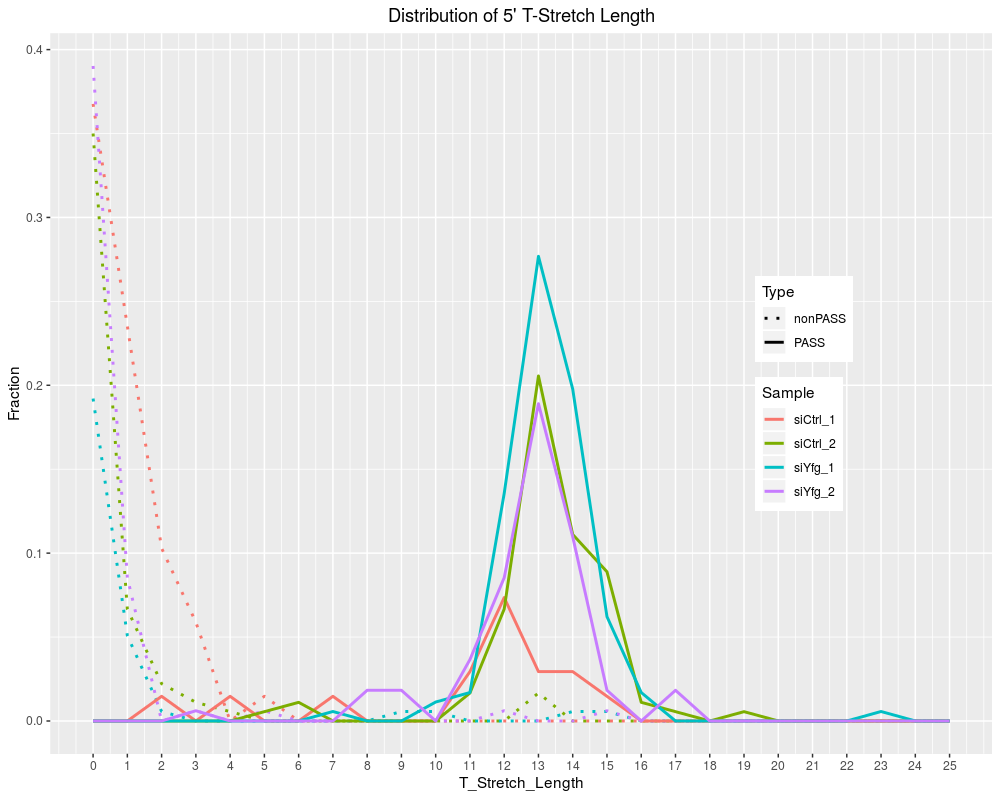

In [79]:
%%R -i result_dir_str,TS -w 1000 -h 800 -r 100

require(dplyr)
require(tidyr)
require(ggplot2)

# Calculation using dplyr and tidyr
TS = mutate(TS, T_Stretch_Length = as.numeric(rownames(TS))) %>% 
     gather(sample_name, Count, -T_Stretch_Length) %>%
     mutate(Type = sub("^.+\\.(.+)$", "\\1", sample_name)) %>%
     mutate(Sample = sub("(^.+)\\..+$", "\\1", sample_name)) %>%
     group_by(Sample) %>% 
     mutate(Fraction = Count/sum(Count))  

# Create plot 
p = ggplot(TS, aes(x = T_Stretch_Length, y = Fraction, color = Sample)) + 
    geom_line(aes(linetype = Type), size = 1) + 
    scale_linetype_manual(values = c(3,1)) +
    scale_x_continuous(breaks = 0:25) +
    theme(legend.position=c(0.8, 0.5))  + 
    ggtitle("Distribution of 5' T-Stretch Length") +
    theme(plot.title = element_text(hjust = 0.5))

# Display in notebook
print(p)

# Save to pdf
pdf(file.path(result_dir_str, 'T_stretch_len_all.pdf'), 8, 6)
print(p)
dev.off()

## Create UCSC genome browser tracks 

In [80]:
# Make UCSC genome browser tracks for PASS reads
make_url(project = PROJECT, experiment = EXPERIMENT, sam_dir= sam_dir, sam_files = pass_files, 
         samtools = samtools, genome_size = genome_size, genomeCoverageBed = genomeCoverageBed, 
         bedGraphToBigWig = bedGraphToBigWig, sample_description = sample_description, processes = WORKERS)

In [81]:
# Prepare for copying files
pass_bw_dir = sam_dir/PROJECT/EXPERIMENT/'PASS'
pass_bw_dir.mkdir(parents=True, exist_ok=True)

os.system(f'mv {str(sam_dir)}/*.bw {str(pass_bw_dir)}')
os.system(f'mv {str(sam_dir)}/bigwigCaller.txt {str(pass_bw_dir)}')

0

In [82]:
# Make UCSC genome browser tracks for nonPASS reads
make_url(project = PROJECT, experiment = EXPERIMENT, sam_dir= sam_dir, sam_files = nonpass_files, 
         samtools = samtools, genome_size = genome_size, genomeCoverageBed = genomeCoverageBed, 
         bedGraphToBigWig = bedGraphToBigWig, sample_description = sample_description, processes = WORKERS)

In [ ]:
# Prepare for copying files
nonpass_bw_dir = sam_dir/PROJECT/EXPERIMENT/'nonPASS'
nonpass_bw_dir.mkdir(parents=True, exist_ok=True)

os.system(f'mv {str(sam_dir)}/*.bw {str(nonpass_bw_dir)}')
os.system(f'mv {str(sam_dir)}/bigwigCaller.txt {str(nonpass_bw_dir)}')

0

In [ ]:
# Copy the bigwig and track definition files to the http-enabled server
cmd = f'scp -r {str(sam_dir/PROJECT)} {USER}@{SERVER}:~/../www/{USER}/bigwig/'
if not os.system(cmd):
    print('bigWig files have been uploaded to http server.')
    
    if SAVE_SPACE:
        cmd = f'rm -r {str(sam_dir)}'
        os.system(cmd)
    
    cmd = f'rm -r {str(sam_dir/PROJECT)}'
    os.system(cmd)
    
    pass_url = (f'https://genome.ucsc.edu/cgi-bin/hgTracks?db={GENOME}'
                f'&position=chr17%3A35092728-35095537&hgct_customText='
                f'http://intron.njms.rutgers.edu/{USER}/bigwig/{PROJECT}/'
                f'{EXPERIMENT}/PASS/bigwigCaller.txt'
                )    

    print('The following URL for PASS reads will be opened in a new tab automatically:')
    print(pass_url, '\n')
    sleep(5)
    import webbrowser
    _ = webbrowser.open(pass_url)

    nonpass_url = (f'https://genome.ucsc.edu/cgi-bin/hgTracks?db={GENOME}'
                   f'&position=chr17%3A35092728-35095537&hgct_customText='
                   f'http://intron.njms.rutgers.edu/{USER}/bigwig/{PROJECT}/'
                   f'{EXPERIMENT}/nonPASS/bigwigCaller.txt'
                   ) 

    print('The following URL for nonPASS reads will be opened in a new tab automatically:')
    print(nonpass_url)
    sleep(5)
    _ = webbrowser.open(nonpass_url)

else:
    print('Cannot upload bigWig files to http server. Please make sure the server is available.')

**This is the end for this notebook. The pA cluster files can be used for further analysis.**